**Maestría en Inteligencia Artificial Aplicada**

**Curso: Proyecto Integrador**

**Tecnológico de Monterrey**

**Equipo 9**

**Jorge Luis Arroyo Chavelas (A01793023)**

# Avance 4. Nodelos Alternativos

# Alternative Models

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
       The purpose of this document is to establish a matching score between resumes (referred to as "resources") and job postings (referred to as "tasks") for use in a resource planning application. This matching score will serve as an indicator of the affinity level between them, and will later be utilized in a resource planning application. Our primary objective is to create an algorithm capable of programmatically assessing this number out of plain text. Achieving this goal will enable us to feed future optimization models without the need for expert manual matching.
    </p>
    <p>
        We will outline three approaches to reflect the evolution of Natural Language Processing (NLP) techniques. Initially, we will establish a baseline model using a binary count vectorizer technique, akin to Jaccard similarity. This involves comparing the words present in a resource-task pair and calculating the cosine similarity between the two vectors, essentially measuring their word overlap. Subsequently, we will adopt a more sophisticated approach by employing vector embeddings to capture semantic meanings of words and assess the distances between word vectors, thereby moving beyond mere word matching to consider the semantic context of words. The third approach builds upon the second by incorporating transformer models to evaluate sentence similarity not only using words but the inner context of sentences.
    <p>
        To facilitate this, we will employ a previously developed BERT Classifier designed to categorize text into distinct categories such as education, experience, and skills. Similarity measures will be applied to each category, and an aggregate average will be computed to produce a unique matching score for each resource-task pair, represented as a number between 0 and 1, being 1 a full a match and a 0 no match at all.
    </p>
    <p>
        With these objectives in mind, let us commence the experimental phase and delve into some computational alchemy!!
    </p>
</div>

In [150]:
## Env and interface libraries
import os
from dotenv import load_dotenv
from tqdm.auto import tqdm

## Data call and manipulation
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

## NLP
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
import gensim.downloader as api


## ML/DL
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from openai import OpenAI


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Call env variables
load_dotenv()

# Select torch device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Ensure you have the stopwords downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dataalchemist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Data

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
      Let's first choose between csv and direct db data.
    </p>
</div>

In [2]:
## Choose if you have access to postgres DB or not.
DB_ACCESS = True

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Now, we gather the resource data. The resource data is already structured with parsed information on education, experience, and skills, eliminating the need for further classification at this stage. We will select 300 resumes from fields related to programming and data analysis by searching for key terms such as "data," "Python," "JavaScript," etc., within the text and titles. This process will enable us to identify profiles that potentially match specific tasks, thereby setting the stage for a targeted evaluation of how these profiles align with the requirements of various job postings.
    </p>
</div>

In [3]:
## Call resource data - either from DB or from a csv file
if DB_ACCESS:
    DATABASE_URL = os.getenv("DATABASE_URL", "")
    SQL_QUERY = """
        SELECT	resource_title, resource_text
                , resource_education
                , resource_experience
                , resource_skills
        FROM	ml_resource
        WHERE 	resource_text ~* '(html|javascript|python|data science|data engineering|css|scrum|designer)'
                OR resource_title ~* '(data|developer)'
        ORDER BY random() 
        LIMIT 	300;
        """
    engine = create_engine(DATABASE_URL)
    resource_data = pd.read_sql(text(SQL_QUERY), engine.connect())
    resource_data.to_csv('./resource_data.csv', index=False)
else: 
    resource_data = pd.read_csv('./resource_data.csv')
    resource_data = resource_data[['resource_title', 'resource_text', 'resource_education', 'resource_experience', 'resource_skills']]

# Visualize data
display(resource_data.head(2))

,resource_title,resource_text,resource_education,resource_experience,resource_skills
0,senior software developer,"Jessica Claire\nMontgomery Street, San Francis...",Education\nAssociates Degree: Computer Science...,"Experience\nSenior Software Developer, 06/2009...","APS, COBOL, TSO-ISPF, OS-MVS JCL, IBM Utilitie..."
1,ui developer,"Jessica Claire\nMontgomery Street, San Francis...",Education\nMaster: Computer Applications\n\nBe...,"Experience\nUI developer, 01/1 - Current\nSagg...","Technological Proficiencies C#, ASP.Net, JavaS..."


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        In contrast, the task data necessitates parsing with our classifier. Additionally, since this data is in HTML format, some extra cleaning steps are necessary. We will begin by extracting data from our database using keywords similar to those employed for the resources, aiming to retrieve 100 relevant cases. Once we have this data, and after parsing the full descriptions, we will use our classifier to create columns for education, experience, and skills. This structured approach will furnish us with the necessary data columns to calculate the matching score between resources and tasks.
    </p>
    <p>
        Please note that the CSV data, which serves as the default method when direct access to the database is unavailable, already includes the cleaning steps outlined above. This ensures that, even in the absence of direct database access, we can still proceed with our analysis using pre-cleaned and structured data and that is also applicable if access to the BERT classifier trainner model is not available.
    </p>
</div>

In [4]:
## Call and prepare task data - either from DB or from csv file
if DB_ACCESS:
    DATABASE_URL = os.getenv("DATABASE_URL", "")
    SQL_QUERY = """
        SELECT 	job_title as task_title, job_html
        FROM 	ml_task
        WHERE 	job_description ~* '(html|javascript|python|data science|data engineering|css|scrum)'
                OR job_title ~* '(data|developer)'
        ORDER BY random() 
        LIMIT 	100;                     
        """
    engine = create_engine(DATABASE_URL)
    task_data = pd.read_sql(text(SQL_QUERY), engine.connect())

    # -----------------------------------------------------------------------------------------------
    # Data is coming from the system with HTML format, let's parse that
    # -----------------------------------------------------------------------------------------------

    # HTML parser function
    def clean_html(raw_html):
        soup = BeautifulSoup(raw_html, 'html.parser')

        # Iterate through all elements in the parsed HTML
        output = []
        for element in soup.find_all():
            if element.name in ['div', 'p']:
                output.append('\n') 
            else:
                output.append(element.get_text().strip())

        cleaned_text = ' '.join(output) 

        cleaned_text = re.sub(r'\n+', '\n', cleaned_text)
        cleaned_text = cleaned_text.replace(u'\xa0', u' ')

        return cleaned_text


    # Parse HTML data into text
    task_data['task_text'] = task_data['job_html'].apply(clean_html)
    task_data.drop('job_html', axis=1, inplace=True)

    # -----------------------------------------------------------------------------------------------
    # Now, the data doesn't contain the education, experience and skills columns, let's add those.
    # -----------------------------------------------------------------------------------------------

    # Load the BERT Classifier
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model_path = "../scoring/classifier.pth"
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    categories = ['education', 'experience', 'skills']
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Function to consume text and return line by line into one of the three categories as a dict
    def predict_multi(text):
        lines = text.split('\n')
        results = {"education": [], "experience": [], "skills": []}

        for line in lines:
            if not line.strip():  # Skip empty lines
                continue

            inputs = tokenizer(line, padding=True, truncation=True, max_length=256, return_tensors="pt")

            with torch.no_grad():
                outputs = model(**inputs)

            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class_index = probabilities.argmax().item()
            predicted_category = categories[predicted_class_index]

            results[predicted_category].append(line)

        return results
    
    # Join the parsed data to original data    
    results_task = task_data['task_text'].apply(predict_multi)
    results_task_df = results_task.apply(pd.Series)
    task_data = task_data.join(results_task_df)

    # Some adittional touches
    task_data['task_education'] = task_data['education'].apply(lambda x: '\n'.join(x))
    task_data['task_experience']  = task_data['experience'].apply(lambda x: '\n'.join(x))
    task_data['task_skills']  = task_data['skills'].apply(lambda x: '\n'.join(x))
    task_data = task_data[['task_title', 'task_text', 'task_education', 'task_experience', 'task_skills']]

    # Now that data is parsed, let's return it.    
    task_data.to_csv('./task_data.csv', index=False)

else: 
    task_data = pd.read_csv('task_data.csv')
    

display(task_data.head(2))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,task_title,task_text,task_education,task_experience,task_skills
0,Remote Full Stack Developer,"Remote Full Stack Developer \n \n Designs,...",Basic QualificationsBachelor's degree or equiv...,"Designs, develops, installs, tests and docum...",Remote Full Stack Developer \n Essential J...
1,Salesforce Business Analyst,Capgemini Government Solutions (CGS) LLC is se...,U.S. Citizenship is required.\nBachelor's Degr...,Capgemini Government Solutions (CGS) LLC is se...,Job Responsibilities\nRequired Qualifications\...


## Model 1. Count Vectorizer

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        With both datasets prepared and containing the relevant data, our next step is to construct a baseline model, for that we will use a binary count vectorizer. We will begin by generating the cartesian product of the two datasets to pair each resource with each task. Following this, we will clean the text by removing stopwords, converting all text to lowercase, and eliminating special characters. On this cleaned text, we will apply the binary count vectorizer to each pair of corresponding columns (e.g., education to education, experience to experience, etc.) to calculate the cosine distance between them. The essence of this approach is to assess whether the education section of a task and that of a resource share the same words, and similarly for other sections. A similarity score of 1 indicates a perfect match where all words are identical across the compared sections, whereas a score of 0 denotes no overlap in words, highlighting the absence of similarity between the task and resource in question.
    </p>
    <p>
        Let's first generate the dataset for this model:
    </p>
</div>

In [5]:
# Text to preprocess data
def clean_text(text):
    
    # return nan if not data
    if pd.isna(text):
        return np.nan

    # To lower, without extra spaces or numbers and removing stopwords    
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english'))
    
    return text

# Copy resource_data to clean it
copy_resource = resource_data.copy()

# Clean the columns
for col in ['resource_education', 'resource_experience', 'resource_skills']:
    copy_resource[col] = copy_resource[col].apply(clean_text)

# Remove text and add index
copy_resource.drop(['resource_text'], axis=1, inplace=True)
copy_resource.reset_index(inplace=True)
copy_resource.rename(columns={'index': 'resource_index'}, inplace=True)

# Copy task data to clean it
copy_task = task_data.copy()

# Clean the columns
for col in ['task_education', 'task_experience', 'task_skills']:
    copy_task[col] = copy_task[col].apply(clean_text)

# Remove text and add index
copy_task.drop(['task_text'], axis=1, inplace=True)
copy_task.reset_index(inplace=True)
copy_task.rename(columns={'index': 'task_index'}, inplace=True)

In [6]:
# Cross product of cleand data
countvec_data = copy_resource.merge(copy_task, how='cross')

# See data
countvec_data

,resource_index,resource_title,resource_education,resource_experience,resource_skills,task_index,task_title,task_education,task_experience,task_skills
0,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,0,Remote Full Stack Developer,basic qualificationsbachelors degree equivalen...,designs develops installs tests documents comp...,remote full stack developer essential job func...
1,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,1,Salesforce Business Analyst,us citizenship required bachelors degree compu...,capgemini government solutions cgs llc seeking...,job responsibilities required qualifications e...
2,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,2,Google Cloud API Devleoper,bachelors degree computer science related disc...,kforce client houston tx seeking google cloud ...,responsibilities requirements requirements res...
3,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,3,"Digital Strategist/Digital Art Director, Enter...",bachelors degree equivalent education experien...,digital art director enterprise creative solut...,job description create integrated costeffectiv...
4,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,4,"Lead Software Engineer, Credit Card Platforms",basic qualifications minimum bs ms computer sc...,onemain financial holds strong commitment cust...,looking demonstrable passion technology eg per...
...,...,...,...,...,...,...,...,...,...,...
29995,299,senior supply chain data analyst decision support,education training bs information technology b...,experience senior supply chain data analystdec...,NaN,95,Data Management Principal,requirements years experience one combination ...,job title data management principal duration m...,job title duration location
29996,299,senior supply chain data analyst decision support,education training bs information technology b...,experience senior supply chain data analystdec...,NaN,96,Business Systems Manager,bachelor equivalent work experience four six y...,schneider seeking innovative business systems ...,effective efficient oral written communication...
29997,299,senior supply chain data analyst decision support,education training bs information technology b...,experience senior supply chain data analystdec...,NaN,97,SQL Developer,years experience database development years ex...,discovery heart everything wherever find us ar...,posting notes framingham inclusive culture car...
29998,299,senior supply chain data analyst decision support,education training bs information technology b...,experience senior supply chain data analystdec...,NaN,98,Data Analyst,,kforce client seeking data analyst chandler az...,responsibilities requirements years coding exp...


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        To facilitate the process described, we'll create two functions. The first function will calculate the average similarity across all relevant sections (education, skills, etc.), and the second function will compute the similarity for a specific pair of columns using a count vectorizer.
    </p>
</div>

In [7]:
# Calculate average similarity function:
def calculate_avg_max_sim(row, sim_columns):
    
    # Extract similarity values
    sim_values = [row[col] for col in sim_columns if not np.isnan(row[col])]
    
    # Check if there are any valid similarity values to calculate avg
    if len(sim_values) > 0:
        avg_sim = sum(sim_values) / len(sim_values)
        max_sim = max(sim_values)
    else:
        max_sim = np.nan
        avg_sim = np.nan

    return pd.Series([max_sim, avg_sim], index=['max_sim', 'avg_sim'])


# -----------------------------------------------------------------------------------------------
# Count Vectorizer function
# -----------------------------------------------------------------------------------------------
def calculate_countvec_similarity(row, vectorizer, col1, col2):
    
    # Check if either value in the pair is NaN
    if pd.isnull(row[col1]) or pd.isnull(row[col2]):
        return np.nan
        
    # Create row corpus
    corpus = [row[col1], row[col2]]
    
    # Vectorize the corpus
    vectors = vectorizer.fit_transform(corpus).toarray()

    # Calculate cosine similarity
    cosine_sim = cosine_similarity([vectors[0]], [vectors[1]])[0][0]

    return cosine_sim

# -----------------------------------------------------------------------------------------------
# Compute similitude
# -----------------------------------------------------------------------------------------------

# Initialize the CountVectorizer
vectorizer = CountVectorizer(binary=True)

# Column pairs to process
column_pairs = [
    ('resource_education', 'task_education'),
    ('resource_experience', 'task_experience'),
    ('resource_skills', 'task_skills'),
]

# Calculate similarities
for col1, col2 in column_pairs:
    sim_col_name = f'sim_{col1.split("_")[1]}'
    countvec_data[sim_col_name] = countvec_data.apply(lambda row: calculate_countvec_similarity(row, vectorizer, col1, col2), axis=1)

countvec_data[['max_sim', 'avg_sim']] = countvec_data.apply(calculate_avg_max_sim, axis=1, sim_columns=['sim_education', 'sim_experience', 'sim_skills'])

# reformat data
countvec_data = countvec_data[[
       'resource_index', 'task_index'
     , 'resource_title', 'task_title'
     , 'resource_education', 'task_education', 'sim_education'
     , 'resource_experience', 'task_experience', 'sim_experience'
     , 'resource_skills', 'task_skills', 'sim_skills'
     , 'avg_sim', 'max_sim'
     ]].sort_values(by='max_sim', ascending=False)

countvec_data

,resource_index,task_index,resource_title,task_title,resource_education,task_education,sim_education,resource_experience,task_experience,sim_experience,resource_skills,task_skills,sim_skills,avg_sim,max_sim
7765,77,65,data engineer,Project Manager-Digitization,education training bachelors computer science ...,education bachelors degree computer science in...,0.447214,experience data engineer current principal fin...,thousands us around world wake every day commo...,0.101252,sql transactional replications san technologie...,job responsibilities managing implementation s...,0.025924,0.191463,0.447214
19766,197,66,business data analyst,Corporate Security Specialist,education mba bscchemical engineering bscchemi...,undergraduate degree undergraduate degree unde...,0.000000,professional experience businessdata analyst a...,us citizens authorized work us considered w ca...,0.136528,microsoft word access excel powerpoint,preferred qualifications proficiency ms excel ...,0.372104,0.169544,0.372104
29765,297,65,sharepoint power apps developer,Project Manager-Digitization,education training bachelor science informatio...,education bachelors degree computer science in...,0.365148,experience sharepointpower apps developer curr...,thousands us around world wake every day commo...,0.099693,sharepoint sharepoint online government commun...,job responsibilities managing implementation s...,0.103695,0.189512,0.365148
10504,105,4,sr. software developer,"Lead Software Engineer, Credit Card Platforms",education ms computer science california state...,basic qualifications minimum bs ms computer sc...,0.360041,experience sr software developer ceridian corp...,onemain financial holds strong commitment cust...,0.119551,NaN,looking demonstrable passion technology eg per...,NaN,0.239796,0.360041
15252,152,52,sr. sql etl developer,Human Resources Manager,education training bachelors degree,education experience requirements bachelors de...,0.353553,experience current sr sqletl developer tiaa cr...,duties responsibilities administers recruitmen...,0.092726,rdbms databases ms sql server msaccess languag...,reports center director salaried exempt positi...,0.051112,0.165797,0.353553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26988,269,88,edi specialist,Porter,educational background bs business marketing u...,,0.000000,work experience current edi specialist aetna i...,porter need skilled maintaining safe clean ret...,0.000000,customer service expert strong organizational ...,,0.000000,0.000000,0.000000
22388,223,88,learning consultant author,Porter,education western governors university bachelo...,,0.000000,professional experience manhattan associates l...,porter need skilled maintaining safe clean ret...,0.000000,NaN,,NaN,0.000000,0.000000
11675,116,75,data entry specialist,Senior .NET Developer,education training ged colleton adult learning...,minimum qualifications minimum qualifications ...,0.000000,experience data entry specialist current tri r...,,0.000000,data input data auditing error verification da...,minimum qualifications,0.000000,0.000000,0.000000
13175,131,75,network security engineer,Senior .NET Developer,education training associate arts criminal jus...,minimum qualifications minimum qualifications ...,0.000000,experience current network security engineer h...,,0.000000,telecommunications systems protecting networks...,minimum qualifications,0.000000,0.000000,0.000000


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Having our data prepared, we can proceed to generate a histogram of the avg similarities and a table with the result of similarities to reiew the results.
    </p>
</div>

In [8]:
# -----------------------------------------------------------------------------------------------
# Function to plot similarities
# -----------------------------------------------------------------------------------------------
def plot_similarity_distributions(df, column, title):
    # Select the similarity scores
    sim_scores = df[column].dropna()

    # Set up the matplotlib figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.suptitle(f'Similarity Score Distribution for {title}')

    # Histogram of the similarity scores
    axes[0].hist(sim_scores, bins=20, color='skyblue', edgecolor='black')
    axes[0].set_title('Histogram of Similarity Scores')
    axes[0].set_xlabel('Similarity Score')
    axes[0].set_ylabel('Frequency')

    # Boxplot of the similarity scores
    axes[1].boxplot(sim_scores, vert=True, patch_artist=True)
    axes[1].set_title('Boxplot of Similarity Scores')
    axes[1].set_xlabel('Similarity Score')
    axes[1].set_ylabel('Value')

    # Display the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# -----------------------------------------------------------------------------------------------
# Function to print similarities
# -----------------------------------------------------------------------------------------------
def print_summary_table(df):
    # Define the table and its column names
    table = PrettyTable()
    table.field_names = ["Category", "Mean", "Median", "Std Dev", "Min", "Max"]

    # List of categories to include in the summary
    categories = ['education', 'experience', 'skills', 'avg_sim']

    # Iterate over each category to calculate summary statistics and add rows to the table
    for category in categories:
        # For 'avg_sim', the column name doesn't follow the 'sim_{category}' pattern
        column_name = category if category == 'avg_sim' else f'sim_{category}'
        
        # Calculate summary statistics
        mean_val = df[column_name].mean()
        median_val = df[column_name].median()
        std_dev_val = df[column_name].std()
        min_val = df[column_name].min()
        max_val = df[column_name].max()

        # Add a row for the current category
        table.add_row([
            category.capitalize(), 
            f"{mean_val:.2f}", 
            f"{median_val:.2f}", 
            f"{std_dev_val:.2f}", 
            f"{min_val:.2f}", 
            f"{max_val:.2f}"
        ])

    # Print the table
    print(table)

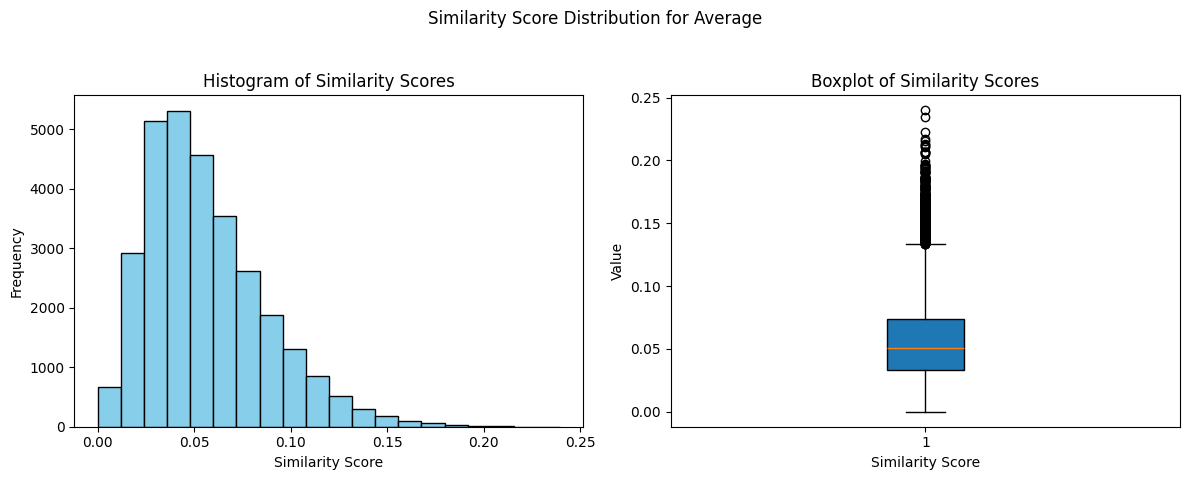

+------------+------+--------+---------+------+------+
|  Category  | Mean | Median | Std Dev | Min  | Max  |
+------------+------+--------+---------+------+------+
| Education  | 0.03 |  0.00  |   0.05  | 0.00 | 0.45 |
| Experience | 0.10 |  0.10  |   0.04  | 0.00 | 0.28 |
|   Skills   | 0.03 |  0.00  |   0.05  | 0.00 | 0.37 |
|  Avg_sim   | 0.06 |  0.05  |   0.03  | 0.00 | 0.24 |
+------------+------+--------+---------+------+------+


In [9]:
plot_similarity_distributions(countvec_data, 'avg_sim', 'Average')
print_summary_table(countvec_data)

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        The main observation of this model is that the similarity scores are quite low when using only coincidence in words, as we are observing aroound a 5~6% in simmilarity averages.
    </p>
    <p>
        To understand this a little better, we will call the 10 best matching titles to do a human evaluation of how well a title of a candidate matches the title of the position.
    </p>
</div>

In [10]:
# Data list
countvec_data[['task_title', 'resource_title', 'avg_sim']]

,task_title,resource_title,avg_sim
7765,Project Manager-Digitization,data engineer,0.191463
19766,Corporate Security Specialist,business data analyst,0.169544
29765,Project Manager-Digitization,sharepoint power apps developer,0.189512
10504,"Lead Software Engineer, Credit Card Platforms",sr. software developer,0.239796
15252,Human Resources Manager,sr. sql etl developer,0.165797
...,...,...,...
26988,Porter,edi specialist,0.000000
22388,Porter,learning consultant author,0.000000
11675,Senior .NET Developer,data entry specialist,0.000000
13175,Senior .NET Developer,network security engineer,0.000000


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        The results of our baseline model are not working very well, it is difficult to see a project manager working as a data engineer; at least is difficult to visualize it as the first choice, having indeed data engineers in the position! Howerver, the model works, it returns a score between 0 and 1 and thus it can be used in further optimization implementations as an input for affinity score.
    </p>
</div>

## Model 2. Semantic Embedding Similarity

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        The second approach takes a more nuanced view by treating words as vector embeddings. This method goes beyond the baseline approach of treating words merely as sets of characters, instead, it leverages the inherent meanings and relationships between words to compute similarities. For this purpose, we will utilize the gensim library in conjunction with embeddings from the GloVe dataset, a widely used model for generating word embeddings that encapsulate word meanings in vector space.
    </p>
    <p>
        We will maintain the same data cleaning protocols as in the baseline approach to ensure that only significant words are considered in our analysis.
    </p>
</div>

In [11]:
embed_data = copy_resource.merge(copy_task, how='cross')
embed_data

,resource_index,resource_title,resource_education,resource_experience,resource_skills,task_index,task_title,task_education,task_experience,task_skills
0,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,0,Remote Full Stack Developer,basic qualificationsbachelors degree equivalen...,designs develops installs tests documents comp...,remote full stack developer essential job func...
1,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,1,Salesforce Business Analyst,us citizenship required bachelors degree compu...,capgemini government solutions cgs llc seeking...,job responsibilities required qualifications e...
2,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,2,Google Cloud API Devleoper,bachelors degree computer science related disc...,kforce client houston tx seeking google cloud ...,responsibilities requirements requirements res...
3,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,3,"Digital Strategist/Digital Art Director, Enter...",bachelors degree equivalent education experien...,digital art director enterprise creative solut...,job description create integrated costeffectiv...
4,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,4,"Lead Software Engineer, Credit Card Platforms",basic qualifications minimum bs ms computer sc...,onemain financial holds strong commitment cust...,looking demonstrable passion technology eg per...
...,...,...,...,...,...,...,...,...,...,...
29995,299,senior supply chain data analyst decision support,education training bs information technology b...,experience senior supply chain data analystdec...,NaN,95,Data Management Principal,requirements years experience one combination ...,job title data management principal duration m...,job title duration location
29996,299,senior supply chain data analyst decision support,education training bs information technology b...,experience senior supply chain data analystdec...,NaN,96,Business Systems Manager,bachelor equivalent work experience four six y...,schneider seeking innovative business systems ...,effective efficient oral written communication...
29997,299,senior supply chain data analyst decision support,education training bs information technology b...,experience senior supply chain data analystdec...,NaN,97,SQL Developer,years experience database development years ex...,discovery heart everything wherever find us ar...,posting notes framingham inclusive culture car...
29998,299,senior supply chain data analyst decision support,education training bs information technology b...,experience senior supply chain data analystdec...,NaN,98,Data Analyst,,kforce client seeking data analyst chandler az...,responsibilities requirements years coding exp...


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        We now define the function of similarity by taking each word and sending those to a vector format; the similarity distance will be done at the comparison of those vectors.
    </p>
</div>

In [12]:
# -----------------------------------------------------------------------------------------------
# Vector embedding function:
# -----------------------------------------------------------------------------------------------

# Function to aggregate word embeddings for a piece of text
def calculate_embeding_similarity(text1, text2, word_vectors):
    
    # Function to generate sentence embeddings
    def sentence_embedding(text):
        words = text.split()
        embeddings = [word_vectors[word] for word in words if word in word_vectors]
        if len(embeddings) == 0:
             # Return a nan vector for texts with no words in the vocabulary
            return np.full(word_vectors.vector_size, 0, dtype=float)
        return np.mean(embeddings, axis=0)
    
    # Check for empty or NaN texts
    if pd.isna(text1) or pd.isna(text2):
        return np.nan
    
    # Generate embeddings for each text
    embedding1 = sentence_embedding(text1)
    embedding2 = sentence_embedding(text2)
    
    # Calculate and return the cosine similarity
    return cosine_similarity([embedding1], [embedding2])[0][0]

# -----------------------------------------------------------------------------------------------
# Compute similitude
# -----------------------------------------------------------------------------------------------

# Load pre-trained Word2Vec embeddings
word_vectors = api.load("glove-wiki-gigaword-100")

# Column pairs to process
column_pairs = [
    ('resource_education', 'task_education'),
    ('resource_experience', 'task_experience'),
    ('resource_skills', 'task_skills'),
]

# Calculate similarities
for col1, col2 in column_pairs:
    sim_col_name = f'sim_{col1.split("_")[1]}'
    embed_data[sim_col_name] = embed_data.apply(lambda row: calculate_embeding_similarity(row[col1], row[col2], word_vectors), axis=1)

embed_data[['max_sim', 'avg_sim']] = embed_data.apply(calculate_avg_max_sim, axis=1, sim_columns=['sim_education', 'sim_experience', 'sim_skills'])

# reformat data
embed_data = embed_data[[
       'resource_index', 'task_index'
     , 'resource_title', 'task_title'
     , 'resource_education', 'task_education', 'sim_education'
     , 'resource_experience', 'task_experience', 'sim_experience'
     , 'resource_skills', 'task_skills', 'sim_skills'
     , 'avg_sim', 'max_sim'
     ]].sort_values(by='max_sim', ascending=False)

embed_data

,resource_index,task_index,resource_title,task_title,resource_education,task_education,sim_education,resource_experience,task_experience,sim_experience,resource_skills,task_skills,sim_skills,avg_sim,max_sim
9725,97,25,servicenow business analyst,Senior Java Developer,education training bachelor science accounting...,,0.000000,experience servicenow business analyst current...,senior java developerbcforward currently seeki...,0.988199,waterfall agile methodologies facilitation ski...,,0.000000,0.329400,0.988199
4146,41,46,analyst program project 1,Data Processing Clerk 1-Lockbox,education walden university marina del rey ca ...,months data entry experience demonstrated work...,0.780740,experience hireright inc analystprogramproject...,job descriptionimportant note application proc...,0.987539,establishes shares best practices help identif...,desired qualifications good problem solving sk...,0.934413,0.900897,0.987539
24905,249,5,data analyst and fraud coordinator,Credit Risk Analytics Assoc. - Consumer Data R...,education university winnipeg diploma network ...,years analytics experience demonstrated work m...,0.842304,work history chicago lighthouse data analyst f...,job descriptionimportant note application proc...,0.987405,ms excel sql customer service quality control ...,companys second line defense corporate risk in...,0.868450,0.899386,0.987405
13025,130,25,senior engineer,Senior Java Developer,education vmware certified associate data cent...,,0.000000,experience senior engineer present pepco energ...,senior java developerbcforward currently seeki...,0.987069,networking windows xxpvista ms office x troubl...,,0.000000,0.329023,0.987069
13318,133,18,arena community scrum master developer,Java Software Engineer,education training masters business administra...,years software engineering experience years co...,0.899269,work experience arena community scrum masterde...,job descriptionimportant note application proc...,0.986897,c aspnet adonet css xhtml ajax telerik radcont...,required qualifications desired qualifications...,0.706522,0.864229,0.986897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,7,75,clinical scientist software design engineer,Senior .NET Developer,education ms applied mathematics harvard unive...,minimum qualifications minimum qualifications ...,0.585194,work history current clinical scientist softwa...,,0.000000,code reviews agile linux advanced critical thi...,minimum qualifications,0.382132,0.322442,0.585194
19475,194,75,web developer,Senior .NET Developer,education bachelor science engineering technol...,minimum qualifications minimum qualifications ...,0.577125,work history web developer current audacy inc ...,,0.000000,frontend programming html css ajax react react...,minimum qualifications,0.290196,0.289107,0.577125
2075,20,75,software engineer iv,Senior .NET Developer,education university alabama tuscaloosa tuscal...,minimum qualifications minimum qualifications ...,0.568098,experience change healthcare software engineer...,,0.000000,concepts agile methodology embedded multithrea...,minimum qualifications,0.319818,0.295972,0.568098
4475,44,75,research fellow,Senior .NET Developer,education bachelor science physics carleton co...,minimum qualifications minimum qualifications ...,0.526252,experience research fellow university chicago ...,,0.000000,NaN,minimum qualifications,NaN,0.263126,0.526252


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        And now let's visualize the results
    </p>
</div>

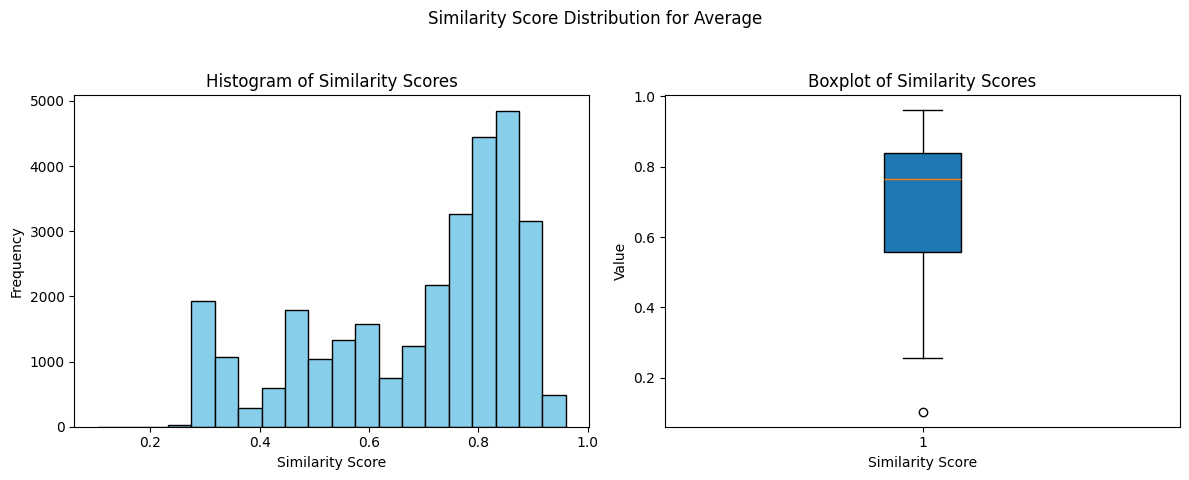

+------------+------+--------+---------+-------+------+
|  Category  | Mean | Median | Std Dev |  Min  | Max  |
+------------+------+--------+---------+-------+------+
| Education  | 0.54 |  0.73  |   0.36  |  0.00 | 0.96 |
| Experience | 0.92 |  0.93  |   0.10  |  0.00 | 0.99 |
|   Skills   | 0.60 |  0.68  |   0.28  | -0.09 | 0.98 |
|  Avg_sim   | 0.69 |  0.76  |   0.19  |  0.10 | 0.96 |
+------------+------+--------+---------+-------+------+


In [13]:
plot_similarity_distributions(embed_data, 'avg_sim', 'Average')
print_summary_table(embed_data)

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        The main observation of this model is how similarities have a very significant increase when compared to the baseline model; as these have increased their average similarity to 0.76.
    </p>
    <p>
        Next we will see some examples of the matches just by their title and matching score
    </p>
</div>

In [104]:
# Data list
embed_data[['task_title', 'resource_title', 'avg_sim']]

,task_title,resource_title,avg_sim
9725,Senior Java Developer,servicenow business analyst,0.329400
4146,Data Processing Clerk 1-Lockbox,analyst program project 1,0.900897
24905,Credit Risk Analytics Assoc. - Consumer Data R...,data analyst and fraud coordinator,0.899386
13025,Senior Java Developer,senior engineer,0.329023
13318,Java Software Engineer,arena community scrum master developer,0.864229
...,...,...,...
775,Senior .NET Developer,clinical scientist software design engineer,0.322442
19475,Senior .NET Developer,web developer,0.289107
2075,Senior .NET Developer,software engineer iv,0.295972
4475,Senior .NET Developer,research fellow,0.263126


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Results through this approach, just by looking at the exampels listed
    </p>

</div>

## Model 3. Context-aware Similarity

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        For our next advancement, we will employ a transformer model, specifically the all-MiniLM-L6-V2, to generate sentence-level similarity. This approach represents a significant enhancement over the previous methods by not only considering the embedded distances between words but also integrating the whole sentence context within which. Unlike the earlier models, here, we will retain stopwords in our analysis to preserve the full semantic structure of the sentences.
    </p>
    <p>
        Let's start with the data:
    </p>
</div>

In [15]:
# Text to preprocess data
def clean_text(text):
    
    # return nan if not data
    if pd.isna(text):
        return np.nan

    # To lower, just words and without extra spaces
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text

# Copy resource_data to clean it
copy_resource = resource_data.copy()

# Clean the columns
for col in ['resource_education', 'resource_experience', 'resource_skills']:
    copy_resource[col] = copy_resource[col].apply(clean_text)

# Remove text and add index
copy_resource.drop(['resource_text'], axis=1, inplace=True)
copy_resource.reset_index(inplace=True)
copy_resource.rename(columns={'index': 'resource_index'}, inplace=True)

# Copy task data to clean it
copy_task = task_data.copy()

# Clean the columns
for col in ['task_education', 'task_experience', 'task_skills']:
    copy_task[col] = copy_task[col].apply(clean_text)

# Remove text and add index
copy_task.drop(['task_text'], axis=1, inplace=True)
copy_task.reset_index(inplace=True)
copy_task.rename(columns={'index': 'task_index'}, inplace=True)

In [16]:
# Cross product of cleand data
transformer_data = copy_resource.merge(copy_task, how='cross')

# See data
transformer_data

,resource_index,resource_title,resource_education,resource_experience,resource_skills,task_index,task_title,task_education,task_experience,task_skills
0,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,0,Remote Full Stack Developer,basic qualificationsbachelors degree or equiva...,designs develops installs tests and documents...,remote full stack developer essential job func...
1,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,1,Salesforce Business Analyst,us citizenship is required bachelors degree in...,capgemini government solutions cgs llc is seek...,job responsibilities required qualifications e...
2,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,2,Google Cloud API Devleoper,bachelors degree in computer science or relat...,kforce has a client in houston tx that is seek...,responsibilities requirements requirements res...
3,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,3,"Digital Strategist/Digital Art Director, Enter...",bachelors degree or equivalent education and e...,as a digital art director in enterprise creati...,job description create integrated and costeffe...
4,0,senior software developer,education associates degree computer science m...,experience senior software developer uniti gro...,aps cobol tsoispf osmvs jcl ibm utilities easy...,4,"Lead Software Engineer, Credit Card Platforms",basic qualifications minimum bs ms computer sc...,onemain financial holds a strong commitment to...,what were looking for demonstrable passion for...
...,...,...,...,...,...,...,...,...,...,...
29995,299,senior supply chain data analyst decision support,education and training bs information technolo...,experience senior supply chain data analystdec...,NaN,95,Data Management Principal,requirements years of experience in one or a ...,job title data management principal duration m...,job title duration location
29996,299,senior supply chain data analyst decision support,education and training bs information technolo...,experience senior supply chain data analystdec...,NaN,96,Business Systems Manager,bachelor or equivalent work experience four to...,schneider is seeking an innovative business sy...,effective and efficient oral and written commu...
29997,299,senior supply chain data analyst decision support,education and training bs information technolo...,experience senior supply chain data analystdec...,NaN,97,SQL Developer,years experience in database development year...,discovery is at the heart of everything we do ...,posting notes framingham ma inclusive culture ...
29998,299,senior supply chain data analyst decision support,education and training bs information technolo...,experience senior supply chain data analystdec...,NaN,98,Data Analyst,,kforce has a client that is seeking a data ana...,responsibilities requirements years of coding ...


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Here, we will encode the columns and then compare them with the all-miniLM-L6-v2 that is a sentence-transformers model. This model maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search. In this case, we will use it just for similarity.
    </p>
</div>

In [17]:
# -----------------------------------------------------------------------------------------------
# Vector embedding function:
# -----------------------------------------------------------------------------------------------

# Function to calculate semantic similarity
def calculate_semantic_similarity(text1, text2, model):
    
    # Check for empty or NaN texts
    if pd.isna(text1) or pd.isna(text2):
        return np.nan
    
    # Encode the texts to get the embeddings
    embeddings = model.encode([text1, text2])
    
    # Calculate cosine similarity
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

# -----------------------------------------------------------------------------------------------
# Compute similitude
# -----------------------------------------------------------------------------------------------


# Load a pre-trained Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')


# Column pairs to process
column_pairs = [
    ('resource_education', 'task_education'),
    ('resource_experience', 'task_experience'),
    ('resource_skills', 'task_skills'),
]

# Calculate similarities
for col1, col2 in column_pairs:
    sim_col_name = f'sim_{col1.split("_")[1]}'
    transformer_data[sim_col_name] = transformer_data.apply(lambda row: calculate_semantic_similarity(row[col1], row[col2], model), axis=1)

transformer_data[['max_sim', 'avg_sim']] = transformer_data.apply(calculate_avg_max_sim, axis=1, sim_columns=['sim_education', 'sim_experience', 'sim_skills'])

# reformat data
transformer_data = transformer_data[[
       'resource_index', 'task_index'
     , 'resource_title', 'task_title'
     , 'resource_education', 'task_education', 'sim_education'
     , 'resource_experience', 'task_experience', 'sim_experience'
     , 'resource_skills', 'task_skills', 'sim_skills'
     , 'avg_sim', 'max_sim'
     ]].sort_values(by='max_sim', ascending=False)

transformer_data

,resource_index,task_index,resource_title,task_title,resource_education,task_education,sim_education,resource_experience,task_experience,sim_experience,resource_skills,task_skills,sim_skills,avg_sim,max_sim
24692,246,92,data entry clerk,Data Entry,education and training business administration...,,-0.033538,experience to current data entry clerk iconma ...,to earn the trust of our employees community c...,0.769120,verifying data accuracy meticulous attention t...,responsibilities adhering to best data managem...,0.514106,0.416563,0.769120
23564,235,64,data base analyst,Lead Analyst - Enterprise Data Quality,education and training bachelor of science inf...,a bachelors degree in computer science or a re...,0.538540,work experience to data base analyst the mark ...,overviewlive the experience from professional ...,0.570427,database administrator dba with experience des...,essentials for success strongly familiar with ...,0.768363,0.625777,0.768363
23327,233,27,hris data coordinator,HR Data Entry Specialist I (11587-1),education master of science marketing college ...,,0.115676,work history to hris data coordinator engie se...,years of experience provides data entry suppo...,0.763377,hris oracle ability to multitask audit prepara...,job description description work environment r...,0.274011,0.384355,0.763377
13112,131,12,network security engineer,Network Architect,education and training associate of arts crimi...,telecommunications knowledge of transmission ...,0.164178,experience to current network security enginee...,summaryshe is to lead andor participate in the...,0.757674,telecommunications systems protecting networks...,description create conceptual diagrams and pre...,0.552902,0.491585,0.757674
17959,179,59,quality engineer ii,"Software Quality Assurance Engineer - Houston, TX",education and training masters management info...,bachelors degree in a relevant field eg comput...,0.458206,work experience to quality engineer ii honeywe...,software quality assurance engineer position w...,0.742327,introduction to oracle i sql programming with ...,duties key responsibilities and critical succe...,0.259021,0.486518,0.742327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22932,229,32,senior assay scientist,Web Developer - Front End (WordPress/PHP),education ms chemical and biochemical engineer...,,-0.017167,experience senior assay scientist to present c...,ledgent technology is seeking a frontend web d...,0.052826,laboratory cell culture molecular cloning main...,comprehensive understanding of wordpress years...,-0.026517,0.003047,0.052826
13555,135,55,ngs data analyst,Cashier-Restaurant Team Member 3rd Shift (BTB)...,education certificate data science john hopkin...,medical dental vision insurance eligible after...,0.000851,experience ngs data analyst current unitypoint...,rd shift cashier here at boston market we are ...,0.052044,excellent handson skills in statistical analys...,discounted meals while youre on the clock pay ...,0.015246,0.022714,0.052044
4788,47,88,molecular biologist,Porter,education phd biotechnology forest research in...,,0.045002,work history to current molecular biologist pa...,as a porter you will need to be skilled mainta...,-0.007584,plasmid modification transformation transfect...,,-0.052577,-0.005053,0.045002
13588,135,88,ngs data analyst,Porter,education certificate data science john hopkin...,,-0.012857,experience ngs data analyst current unitypoint...,as a porter you will need to be skilled mainta...,0.044770,excellent handson skills in statistical analys...,,-0.012991,0.006307,0.044770


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Here are the results:
    </p>
</div>

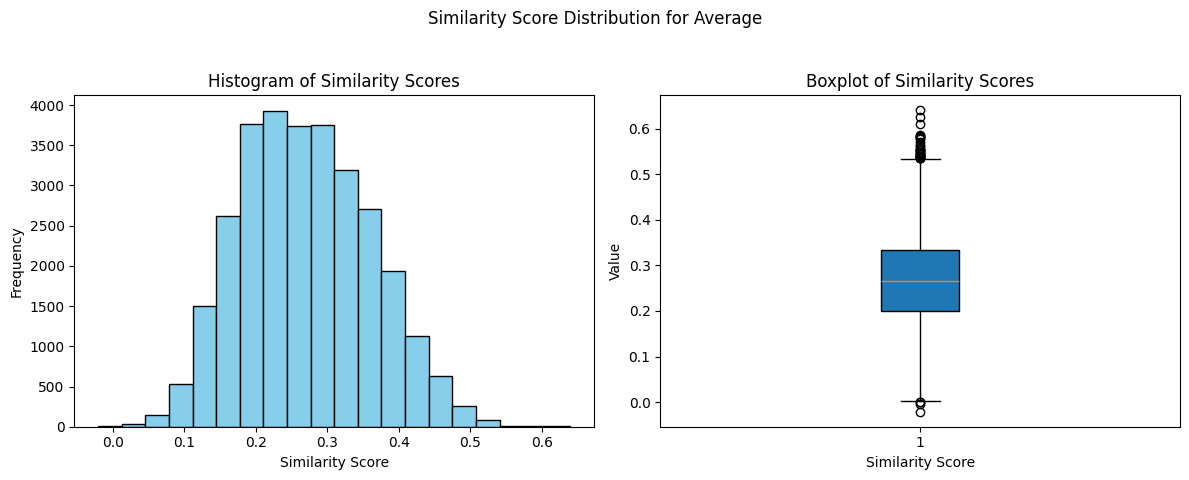

+------------+------+--------+---------+-------+------+
|  Category  | Mean | Median | Std Dev |  Min  | Max  |
+------------+------+--------+---------+-------+------+
| Education  | 0.22 |  0.22  |   0.14  | -0.07 | 0.72 |
| Experience | 0.35 |  0.36  |   0.11  | -0.10 | 0.77 |
|   Skills   | 0.22 |  0.21  |   0.14  | -0.11 | 0.77 |
|  Avg_sim   | 0.27 |  0.26  |   0.09  | -0.02 | 0.64 |
+------------+------+--------+---------+-------+------+


In [106]:
plot_similarity_distributions(transformer_data, 'avg_sim', 'Average')
print_summary_table(transformer_data)

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        A lot of aspects! One, is that the average score decayed when compared to the transformer model; but it is still more significant than the count vectorizer. A second aspect, is the distribution shape that follows a more normal curve pattern, which looks intuitevily good when we think on the underneath data, there are a few who excel at jobs and some that don't but the great majority have a simmilar perfomance.
    </p>
    <p>
        Next we will see some examples of the matches just by their title and matching score
    </p>
</div>

In [105]:
transformer_data[['task_title', 'resource_title', 'avg_sim']]

,task_title,resource_title,avg_sim
24692,Data Entry,data entry clerk,0.416563
23564,Lead Analyst - Enterprise Data Quality,data base analyst,0.625777
23327,HR Data Entry Specialist I (11587-1),hris data coordinator,0.384355
13112,Network Architect,network security engineer,0.491585
17959,"Software Quality Assurance Engineer - Houston, TX",quality engineer ii,0.486518
...,...,...,...
22932,Web Developer - Front End (WordPress/PHP),senior assay scientist,0.003047
13555,Cashier-Restaurant Team Member 3rd Shift (BTB)...,ngs data analyst,0.022714
4788,Porter,molecular biologist,-0.005053
13588,Porter,ngs data analyst,0.006307


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        This, by far is the best model, many of the titles of task and resources are matching!
    </p>
</div>

## Models vs state of the art

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        To this point, we have built 3 models: the count vectorizer, the semantinc embeded and the context-awared and of thoose is the later the one that performs the best. We see that at least for the first visualizations the titles are matching. However, it is a good idea to measure this to an expert opinion, for that purpouse we will take the best 30 matches, this is 30 tasks paired with 30 resumes; we will send this data against the state-of-the-art GPT-4, OPENAI model, and compare a matching score produced by this system comparing experience vs job posting against the results of our context-aware model
    </p>
    <p>
        To do this, let's define a function to send the prompts and data to OPENAI api.
    </p>
</div>

In [130]:
# Function to measure similarity on GPT 
def calculate_gptsim_score(resume_text, job_posting_text):

    client = OpenAI(
      api_key = os.getenv("OPENAI_KEY", "")
    )

    try:
        # Construct a prompt
        messages = [
            { "role": "system",
              "content": "You are an HR guru capable of matching job requirements with resumes using a scale between 0 and 1 as a representation of matching score" 
            },
            { "role": "user",
              "content": f""" Give me a matching score between this RESUME: {resume_text[0:1900]} and this JOB POSTING: {job_posting_text[0:1900]}. Provide answer as a simple number, ntohing else.""" 
            }
        ]

        # Call the OpenAI API with temp 0 to have an strict answer.
        response =  client.chat.completions.create(
            model="gpt-4",
            messages=messages,
            max_tokens=4096,
            temperature=0
        )

        # Extract the score from the response
        score = response.choices[0].message.content
        return score
        
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Process data and dataaset to send.
    </p>
</div>

In [167]:
# Function to process data
def evaluate_model_vs_gpt(df):

    model_list_ed = []
    model_list_xp = []
    model_list_sk = []
    model_list_avg = []
    model_list_max = []
    gpt_list = []

    for index, row in df.iterrows():
        resource_index = row['resource_index']
        task_index = row['task_index']

        resource_text = resource_data.loc[resource_index, 'resource_experience']
        task_text = task_data.loc[task_index, 'task_text']

        model_list_ed.append(row['sim_education'])
        model_list_xp.append(row['sim_experience'])
        model_list_sk.append(row['sim_skills'])
        model_list_avg.append(row['avg_sim'])
        model_list_max.append(row['max_sim'])
        gpt_list.append(calculate_gptsim_score(resource_text, task_text))

    
    evaluated_df = pd.DataFrame({ 
        'iteration': index,
        'model_education': model_list_ed,
        'model_experience': model_list_xp,
        'model_skill': model_list_sk,
        'model_avg': model_list_avg,
        'model_max': model_list_max,
        'gpt_score': gpt_list
        })
    return evaluated_df

# Data to send
top_per_task = transformer_data.groupby('task_index', as_index=False).apply(lambda x: x.sort_values(by='max_sim', ascending=False).head(1)).reset_index(drop=True)

# Now, sort 'top_per_task' by 'max_sim' to get the overall top entries and take the top 30
top_30 = top_per_task.sort_values('max_sim', ascending=False).head(30)

# Reset index if needed
top_30 = top_30.reset_index(drop=True)

top_30[['task_index', 'resource_index', 'resource_title', 'task_title', 'avg_sim', 'max_sim']]

/var/folders/3g/bsyh5znn5tlf6y65fb7bt04h0000gn/T/ipykernel_37873/3254824234.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_per_task = transformer_data.groupby('task_index', as_index=False).apply(lambda x: x.sort_values(by='max_sim', ascending=False).head(1)).reset_index(drop=True)


,task_index,resource_index,resource_title,task_title,avg_sim,max_sim
0,92,246,data entry clerk,Data Entry,0.416563,0.769120
1,64,235,data base analyst,Lead Analyst - Enterprise Data Quality,0.625777,0.768363
2,27,233,hris data coordinator,HR Data Entry Specialist I (11587-1),0.384355,0.763377
3,12,131,network security engineer,Network Architect,0.491585,0.757674
4,59,179,quality engineer ii,"Software Quality Assurance Engineer - Houston, TX",0.486518,0.742327
5,60,3,sr. java quartz developer,VSP Sr. Full Stack Java Prgr,0.330896,0.739596
6,34,43,aws devops engineer,.Net Developer (Remote),0.372897,0.722714
7,56,234,sql server developer dba,SQL DBA,0.392804,0.719485
8,61,24,ui developer,Sr. UI Developer - React,0.365962,0.717242
9,6,89,data engineer,Data Platform Engineer,0.301322,0.712191


<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        Send the data.
    </p>
</div>

In [143]:
# eval model vs GPT-4 
eval_df = evaluate_model_vs_gpt(top_30)


In [171]:
eval_df

,iteration,model_education,model_experience,model_skill,model_avg,model_max,gpt_score
0,29,-0.033538,0.769120,0.514106,0.416563,0.769120,0.9
1,29,0.538540,0.570427,0.768363,0.625777,0.768363,0.7
2,29,0.115676,0.763377,0.274011,0.384355,0.763377,0.85
3,29,0.164178,0.757674,0.552902,0.491585,0.757674,0.85
4,29,0.458206,0.742327,0.259021,0.486518,0.742327,0.85
5,29,0.128395,0.739596,0.124696,0.330896,0.739596,0.9
6,29,0.722714,0.235682,0.160297,0.372897,0.722714,0.2
7,29,0.066122,0.719485,0.397705,0.392804,0.719485,0.95
8,29,0.014681,0.717242,0.397705,0.365962,0.717242,0.85
9,29,0.041811,0.712191,0.149965,0.301322,0.712191,0.85


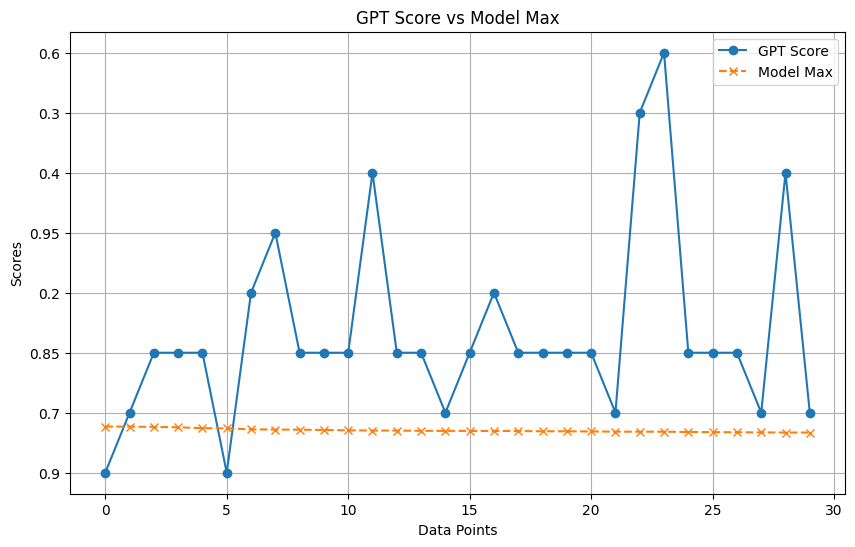

MAE: 0.17


In [178]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(eval_df['gpt_score'], eval_df['model_max'])

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(eval_df['gpt_score'], label='GPT Score', marker='o')
plt.plot(eval_df['model_max'], label='Model Max', linestyle='--', marker='x')
plt.title('GPT Score vs Model Max')
plt.xlabel('Data Points')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.show()

print(f"MAE: {mae:.2f}")

## Conclussions

<div style="background-color: #f4f4e8;
    border: 2px solid #333;
    border-radius: 5px;
    padding: 10px;
    font-family: monospace;
    color: #333;
    max-width: 90%;
    margin: 5px auto;
    position: relative;
    box-shadow: 3px 3px #999;">
    <p>
        In this document we created 3 models for matching score between resumes (resources) and job posts (tasks). We explored a naive method of count vectorizer and we went as far as to a sentence-context-awarness model, we saw that this one the model that perform the best. We even compare against the state of the art GPT-4 our matching score and visualize that in general our model is performing in the same sense as this ground truth, with a MAE of 0.16. In general, this is telling us that we are going in the right direction and that it might be indeed possible to create an affinity or scortint match index between these two datasets that can later be send to an application.
    </p>
</div>

========== END OF ACTIVITY ==========